# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-27 19:08:21 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2023-12-27 19:08:24 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2023-12-27 19:08:26 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [4]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [5]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


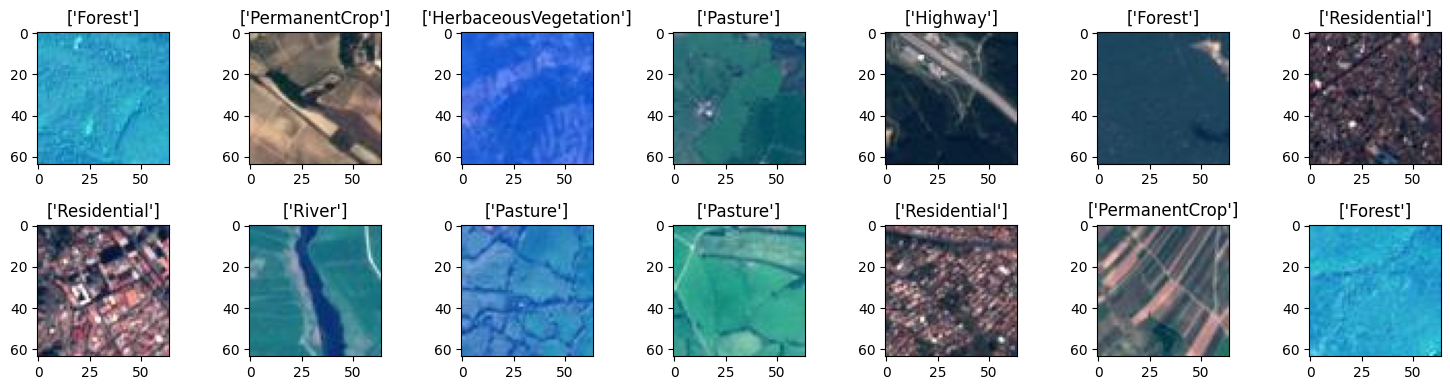

In [6]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [7]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()

# Model

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [8]:
# Prepare data for training
X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)

[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

In [9]:
# Assuming X_train and y_train are PyTorch tensors
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor = torch.stack([transform(img) for img in X_train]).float()
X_valid_tensor = torch.stack([transform(img) for img in X_valid]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)

In [ ]:
# Define the simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # ... (add more layers as needed)
        # self.fc = nn.Linear(..., 10)  # Output has 10 classes
        # YOUR CODE HERE
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 10)  # Output has 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # ... (add forward pass for other layers)
        # YOUR CODE HERE
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # Here, the log is applied after the softmax:
        return F.log_softmax(x, dim=1)

In [10]:
# 2ème étape : ResNet50
fcn = models.resnet50(pretrained=True)
num_ftrs = fcn.fc.in_features
fcn.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.0MB/s]


In [ ]:
#U-Net
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


###############################################################################################################################################
########################################Montage Unet ################################################################################

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        #self.up12 = up(16*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        #self.up22 = up(8*size, 2*size)
        self.up3 = Up(2*size, size)
        #self.up32 = up(4*size, size)
        self.up4 = Up(size, size)
        #self.up42 = up(2*size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes
        # Ajouter une couche de global average pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Ajouter une couche linéaire (fully connected) pour la classification
        self.fc = nn.Linear(32*64, n_classes)

        # Ajouter la couche de softmax
        self.softmax = nn.Softmax(dim=1)  # Assurez-vous de spécifier la dimension appropriée

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        # Appliquer la couche de global average pooling
        #x = self.global_avg_pooling(x)

        # Aplatir les caractéristiques
        #x = x.view(x.size(0), -1)

        # Passer les caractéristiques à travers la couche linéaire
        #x = self.fc(x)

        # Appliquer la couche de softmax
       #x = self.softmax(x)

        x = x.view(x.size(0), -1)  # flatten
        # Réorganiser pour obtenir [batch_size, num_classes]
        x = x.view(x.size(0), -1, 64, 64).sum(dim=(2, 3))
        return x

fcn = UNet(3,10)

In [11]:
# Data augmentation
def custom_transform(X):
  transform = transforms.Compose([
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.GaussianBlur(kernel_size=3),
    #transforms.ToTensor(),
  ])
  return transform(X)

# Créer un TensorDataset avec vos données et utiliser la fonction de transformation au moment de l'accès
class AugmentedTensorDataset(TensorDataset):
    def __getitem__(self, index):
        x, y = super(AugmentedTensorDataset, self).__getitem__(index)
        x = custom_transform(x)
        return x, y

In [24]:
# Instantiate the model
model = fcn.cuda()

# Print the model architecture
#print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

# Training loop
num_epochs = 50
batch_size = 32

# Créer votre ensemble de données avec la data augmentation
#train_dataset = AugmentedTensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [39]:
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for inputs, labels in train_loader:

      inputs = inputs.cuda()
      labels = labels.cuda()

      optimizer.zero_grad()
      outputs = model(inputs)

      outputs = outputs.squeeze()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    incorrect_predictions = []
    true_labels = []
    predicted_labels = []
    images_label_6 = []
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

             # Identifiez les indices des prédictions incorrectes
            incorrect_indices = (predicted != labels).nonzero().squeeze()

            # Identifiez les indices des images avec le label 6
            indices_label_6 = (labels == 6).nonzero().squeeze()
            if indices_label_6.numel() > 1:
              for indice in indices_label_6:
                images_label_6.append({
                    'image': inputs[indice].cpu(),
                    'predicted_label': predicted[indice].item()
                })

            # Récupérez les images, étiquettes et prédictions incorrectes
            if incorrect_indices.numel() > 1:
              for i in incorrect_indices:
                  incorrect_predictions.append({
                      'image': inputs[i].cpu(),
                      'true_label': labels[i].item(),
                      'predicted_label': predicted[i].item()
                  })
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {valid_loss / len(valid_loader):.3f}, Accuracy: {100*accuracy:.2f}%')


Epoch 1/50, Validation Loss: 0.207, Accuracy: 95.38%
Epoch 2/50, Validation Loss: 0.275, Accuracy: 94.27%


KeyboardInterrupt: ignored

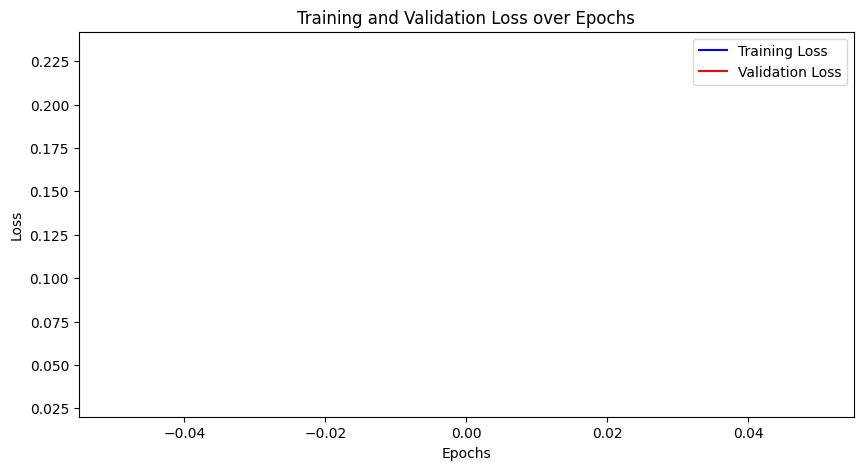

In [33]:
# Tracé de l'évolution de la loss au fil des epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

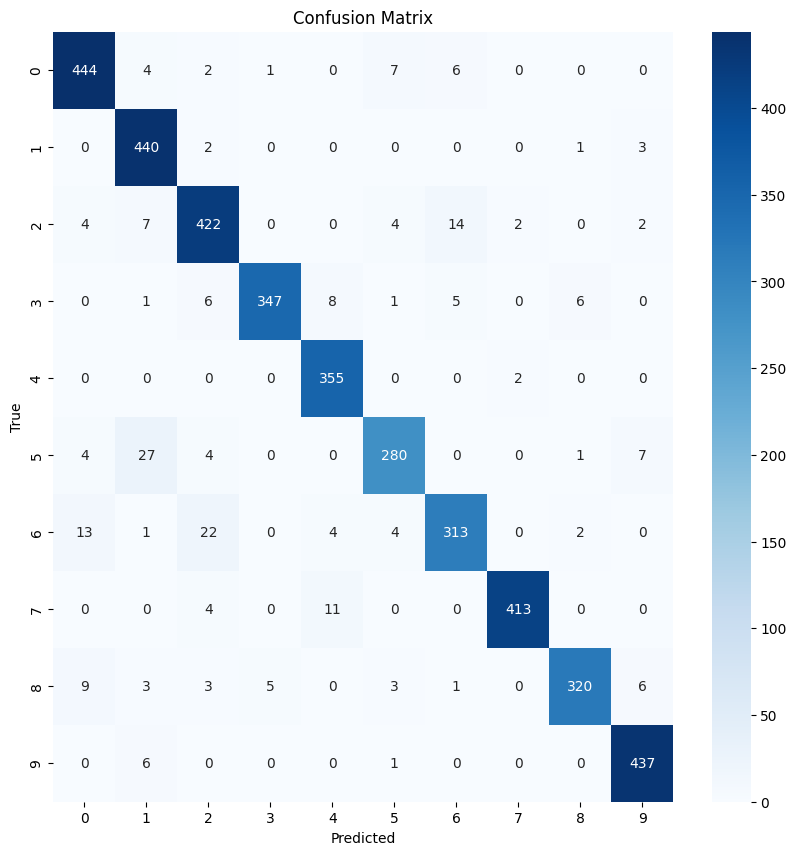

Recall: 0.943
F1 Score: 0.943


In [40]:
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour créer et afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1_score:.3f}')

IndexError: ignored

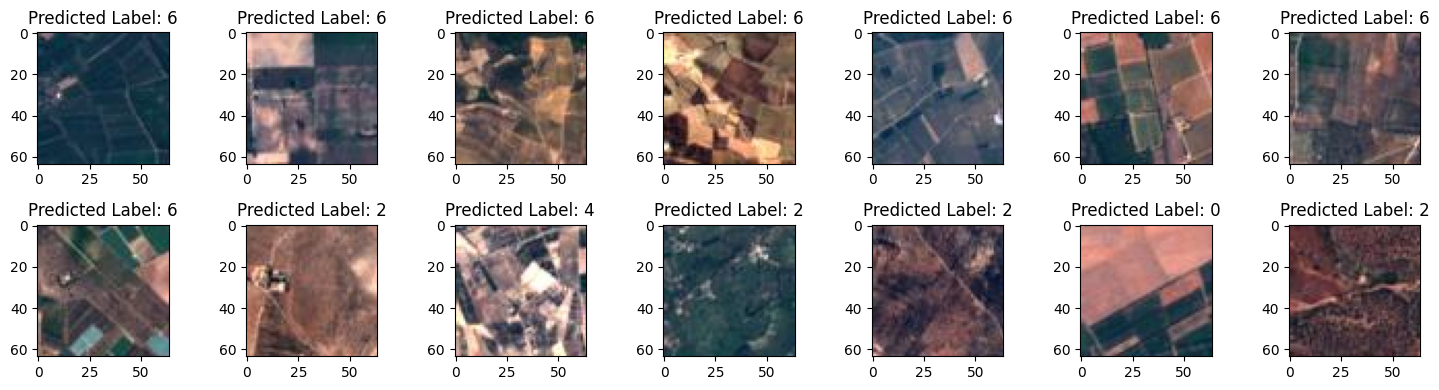

In [50]:
denormalize = transforms.Compose([
    transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std]),
    transforms.ToPILImage()
])
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()

j = 0

for prediction in images_label_6:
  if j <= 14:
    image = prediction['image']
    label = prediction['predicted_label']

    img_denormalized = denormalize(image)

    axes[j].imshow(img_denormalized)
    axes[j].set_title(f'Predicted Label: {label}')

    if j <= 7:
      j += 1
    # Utilisez la librairie matplotlib ou tout autre moyen pour afficher les images
    if label != 6:
        axes[j].imshow(img_denormalized)
        axes[j].set_title(f'Predicted Label: {label}')
        j += 1
  plt.tight_layout()

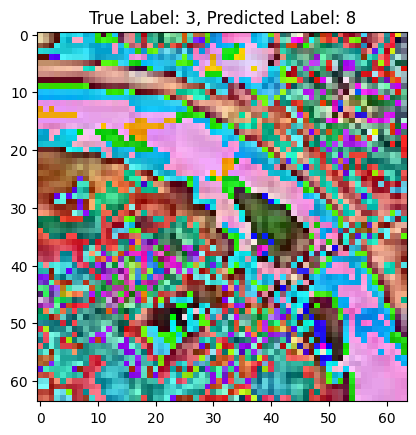

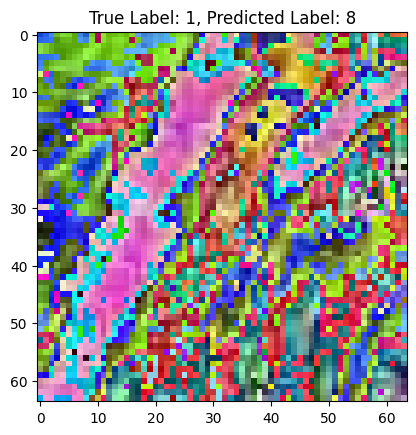

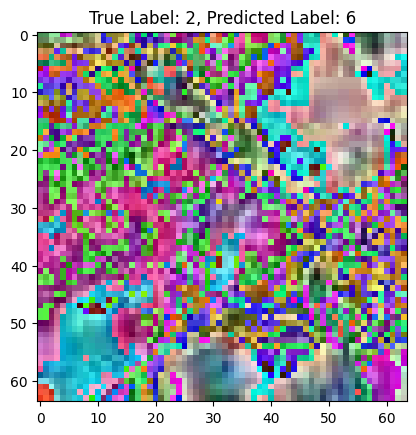

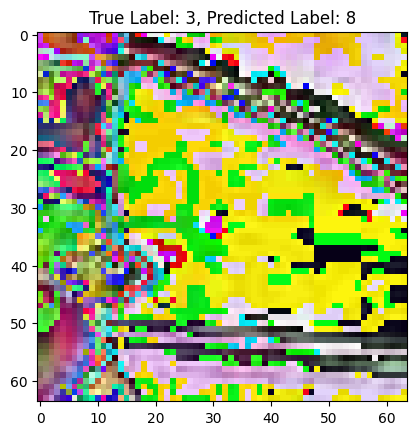

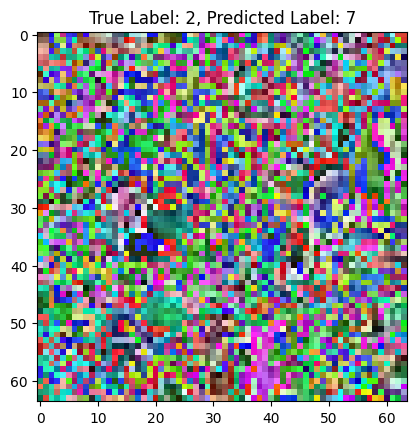

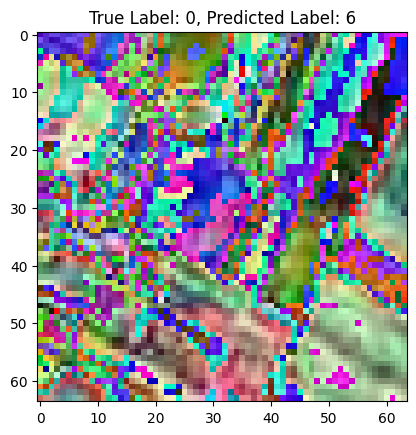

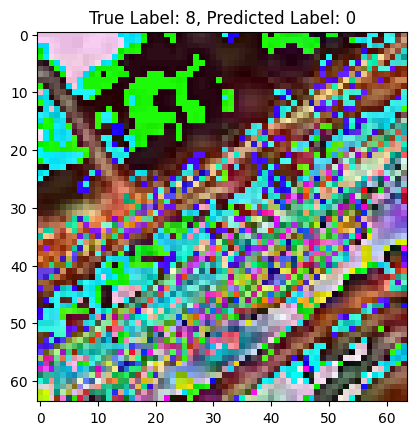

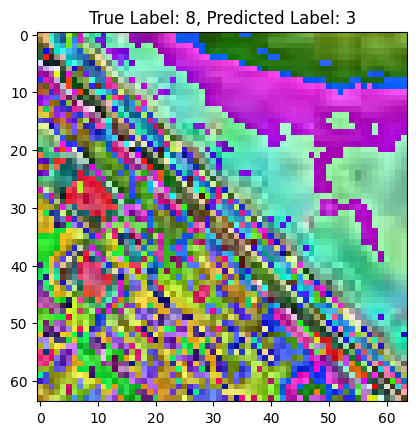

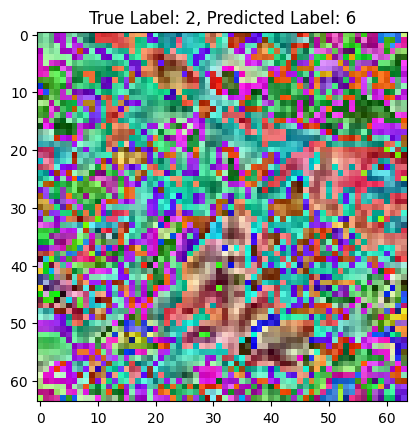

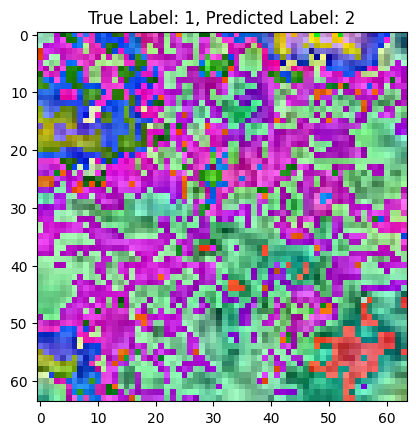

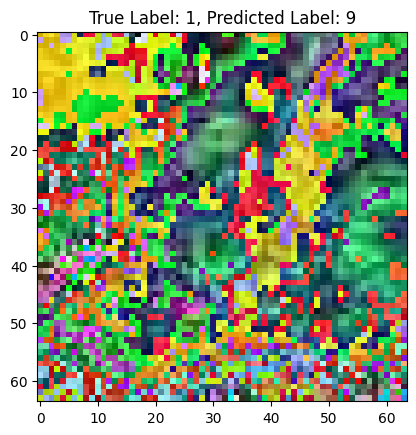

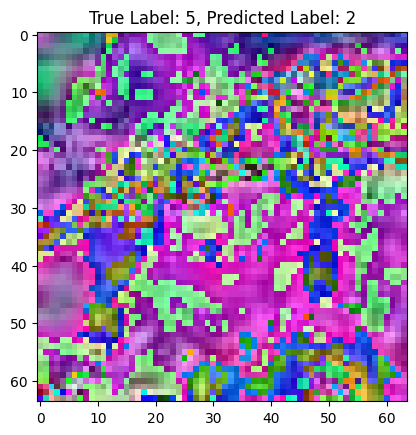

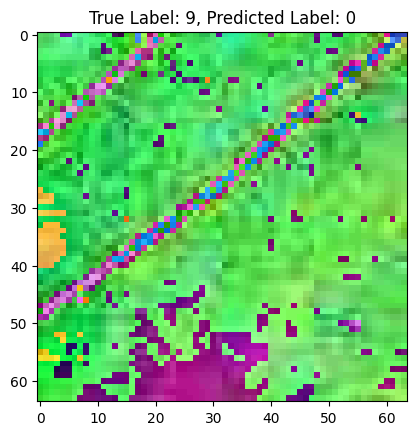

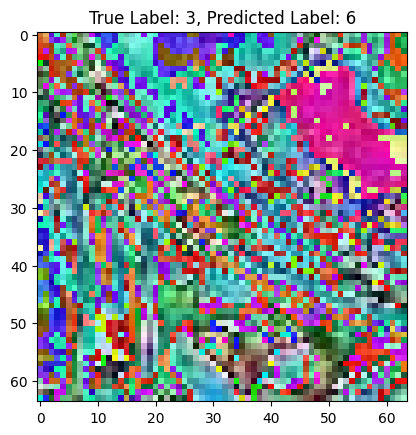

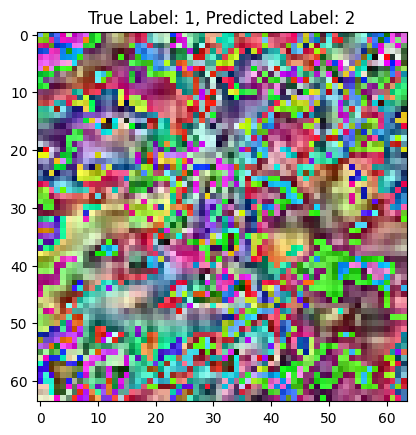

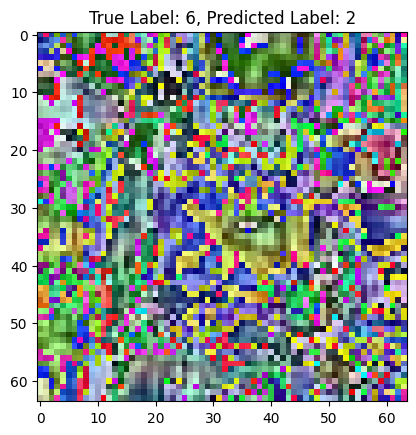

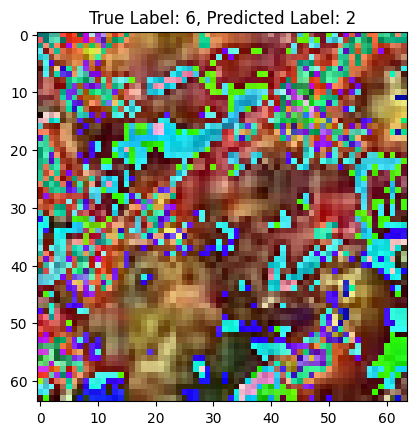

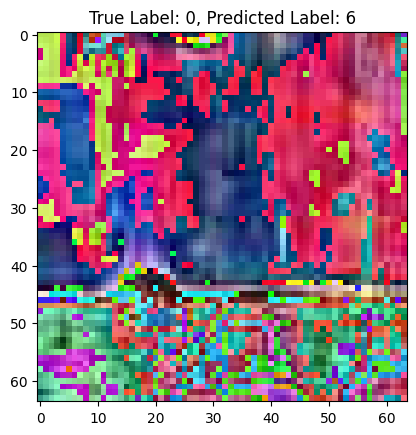

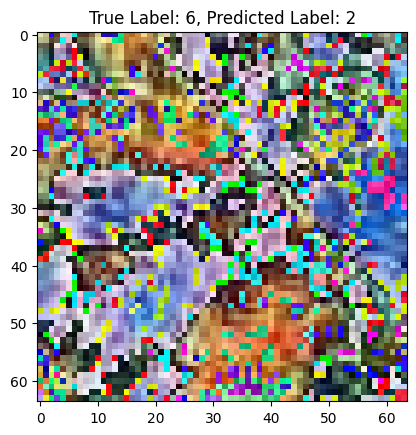

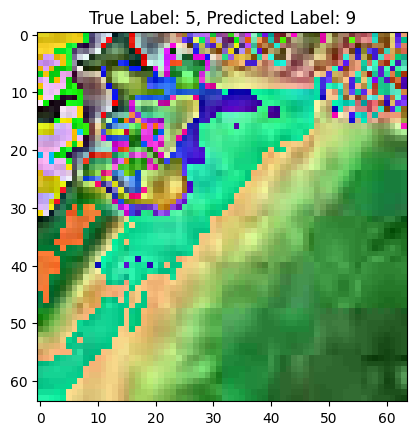

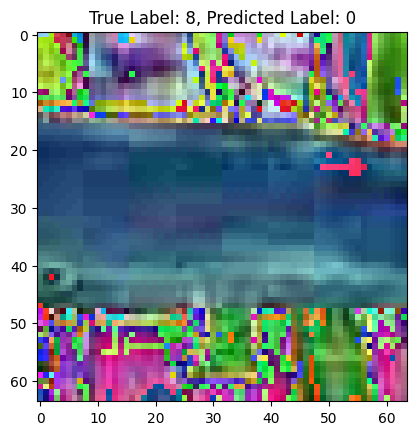

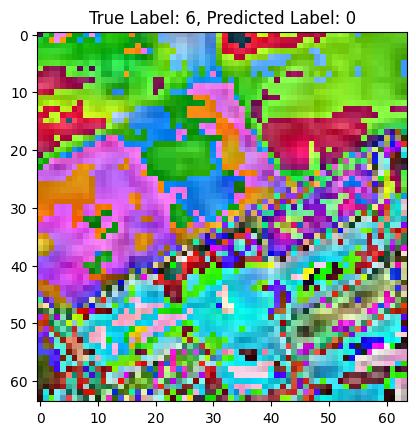

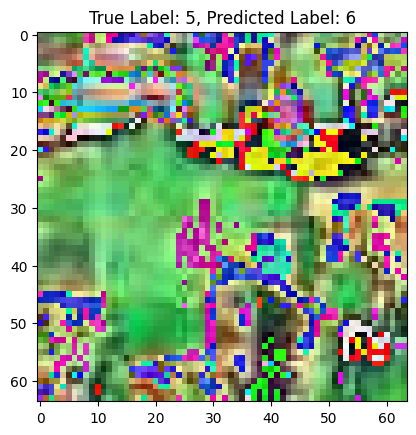

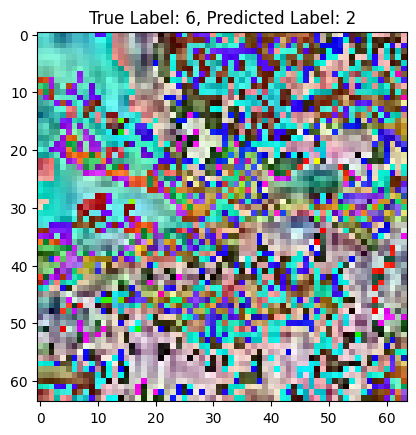

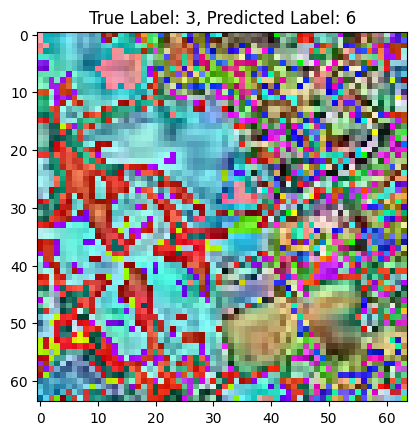

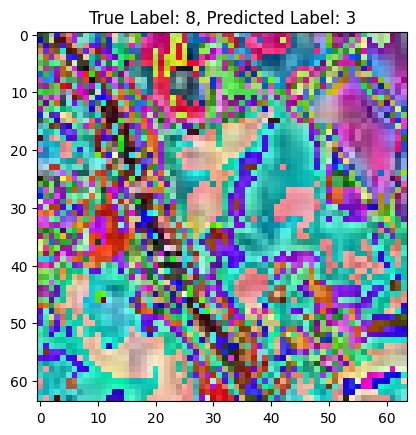

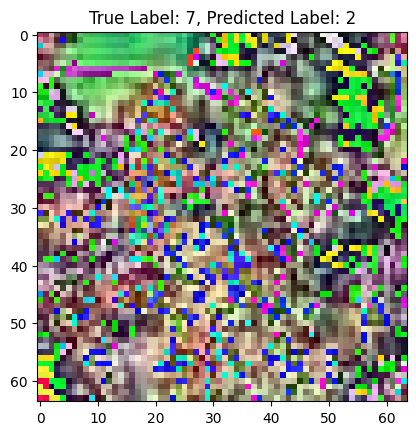

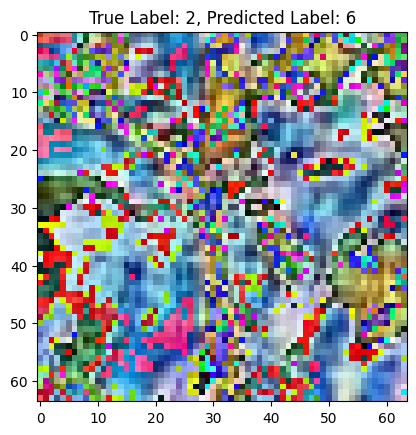

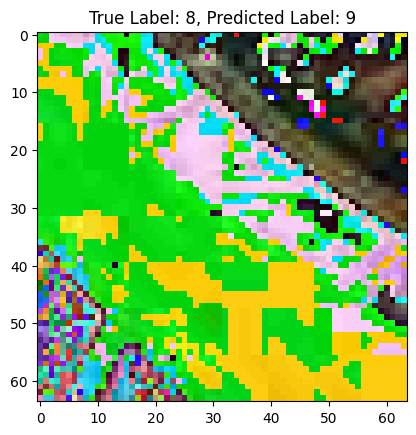

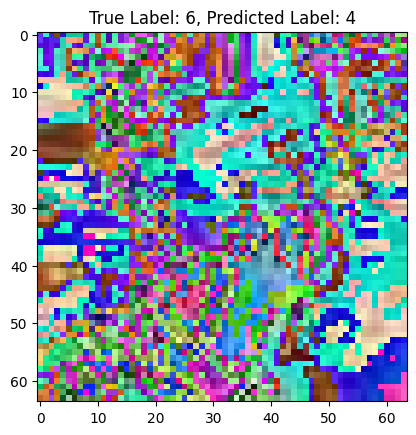

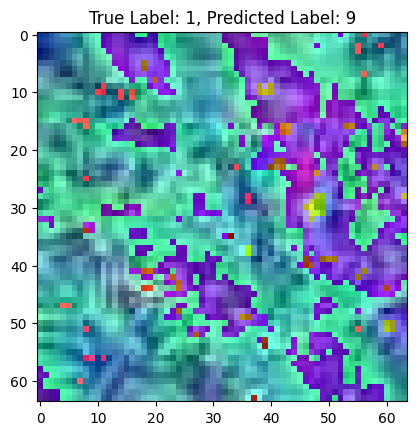

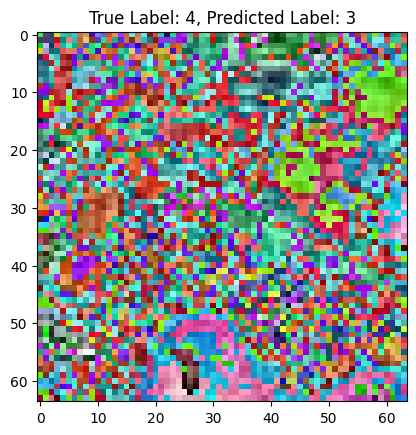

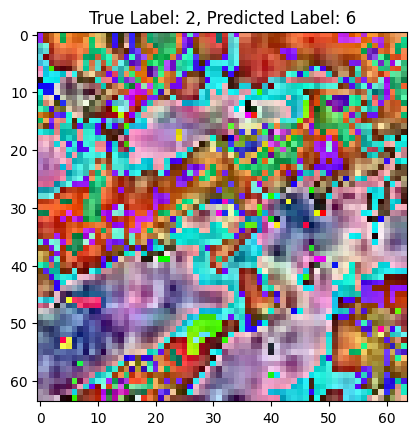

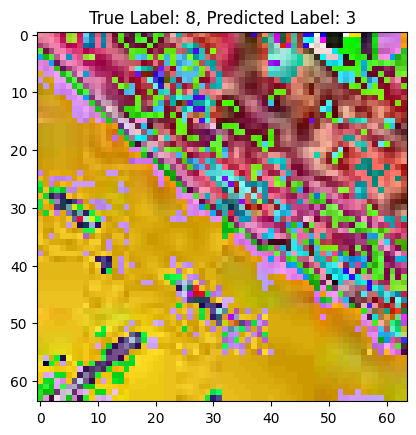

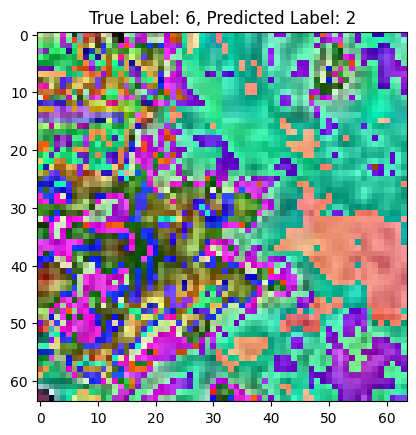

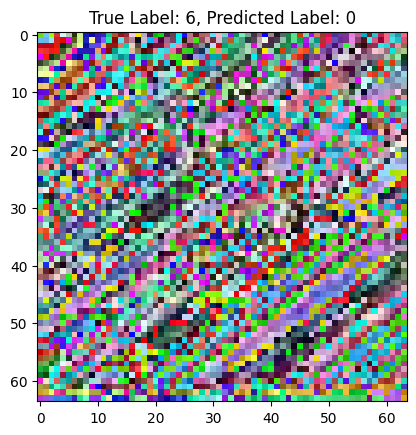

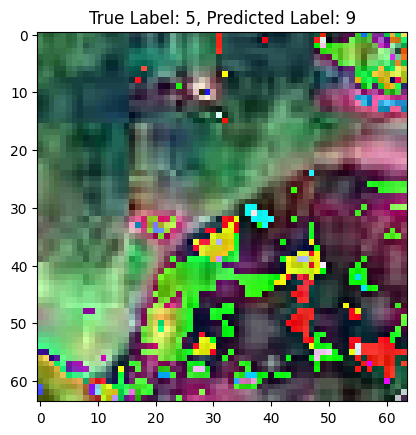

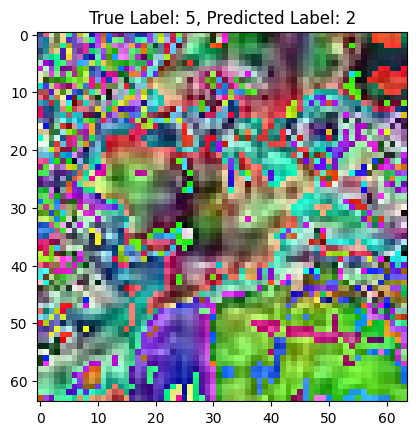

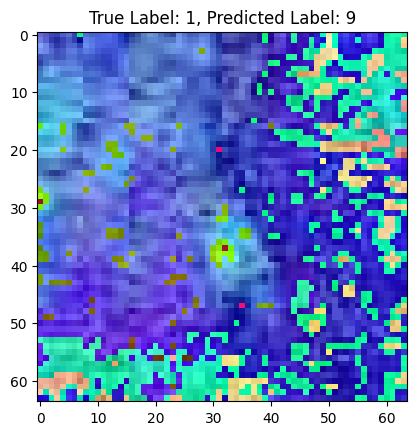

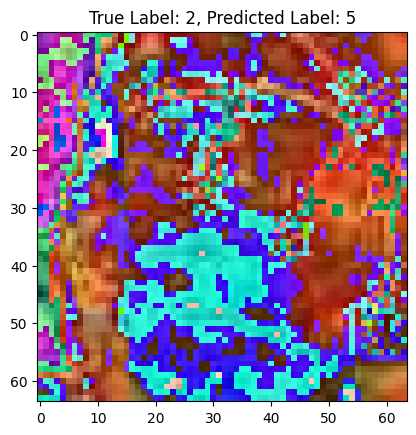

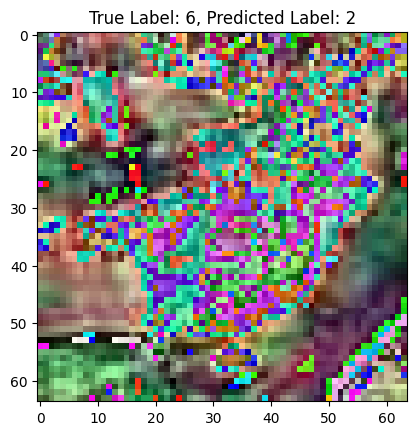

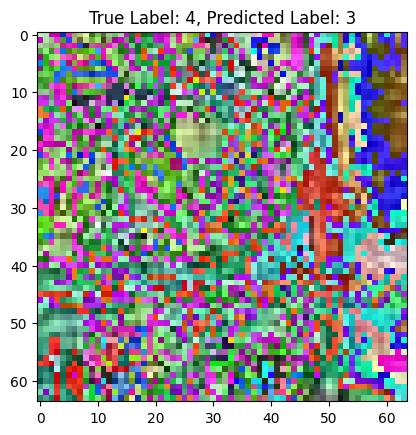

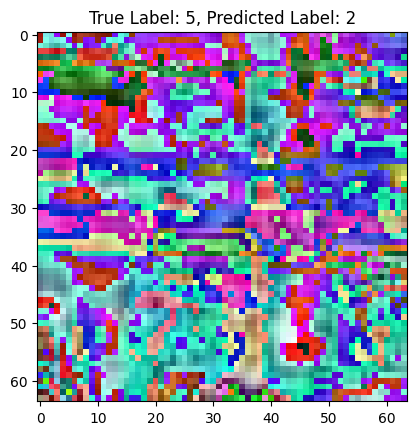

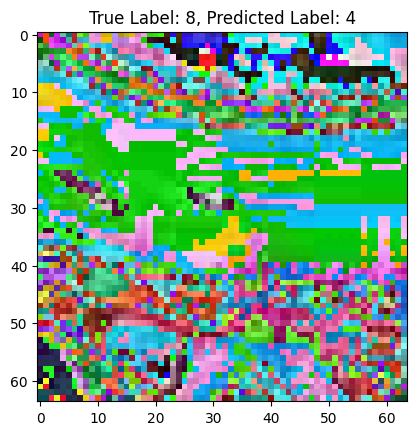

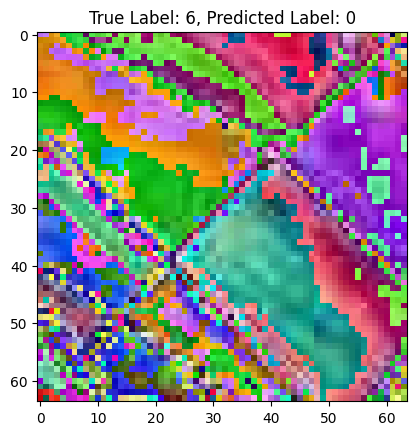

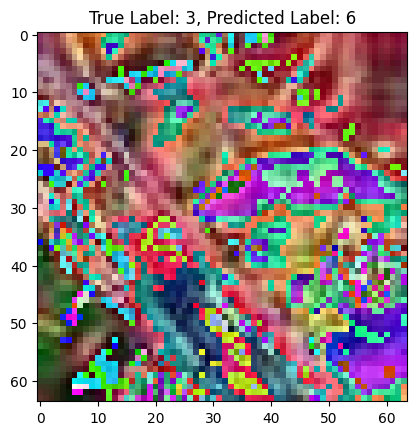

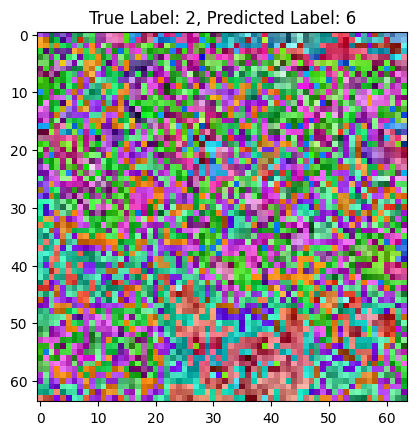

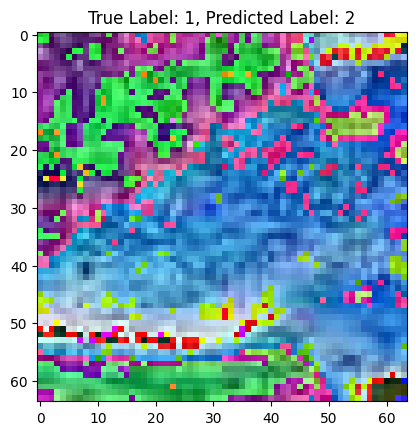

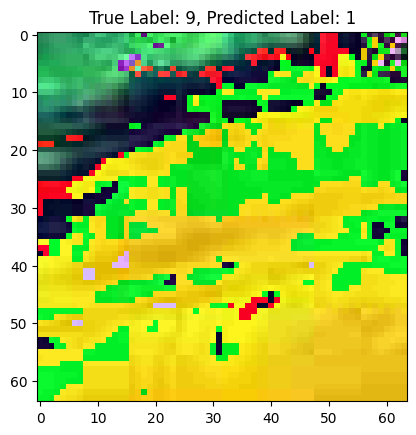

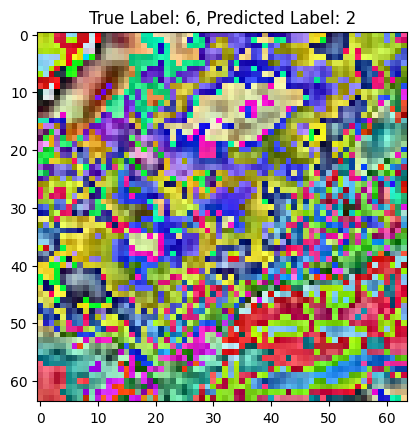

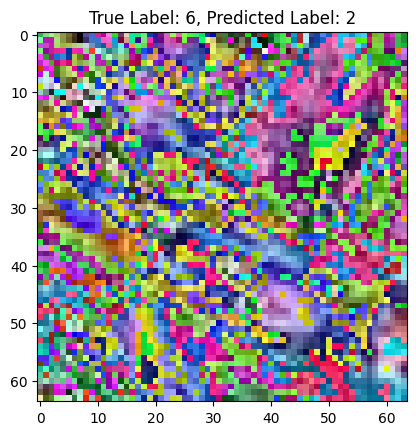

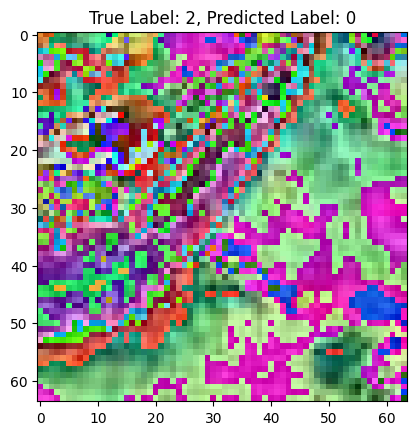

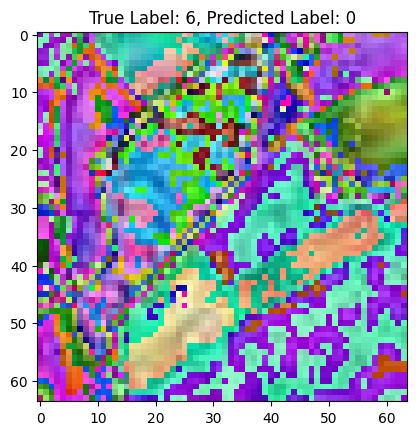

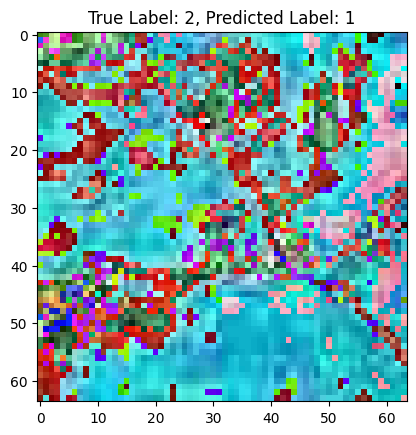

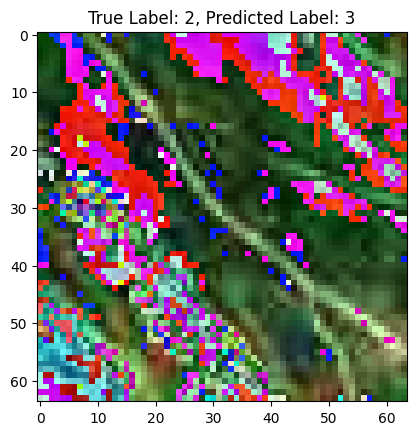

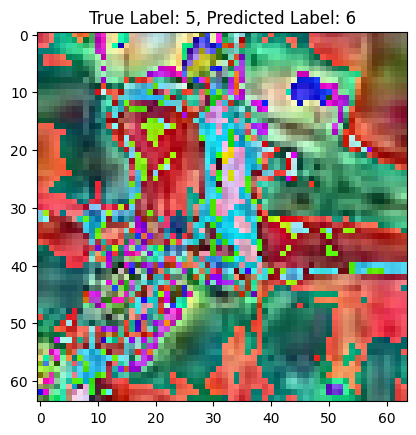

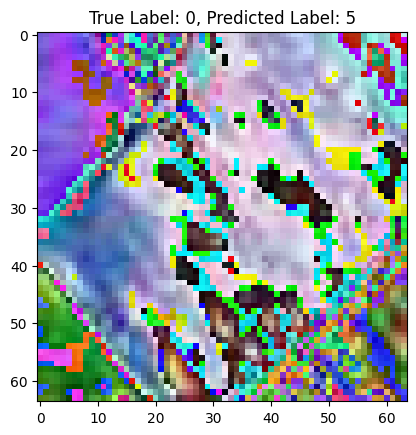

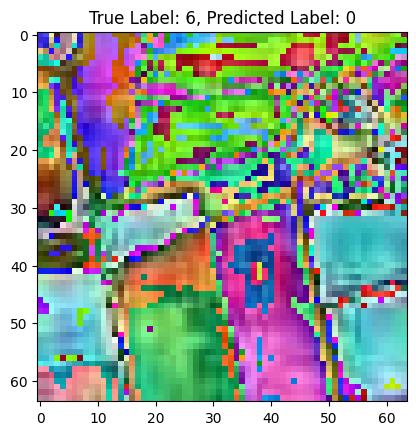

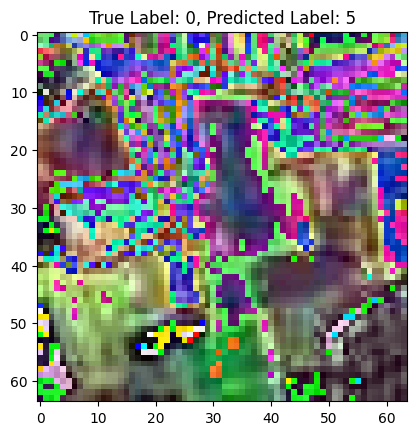

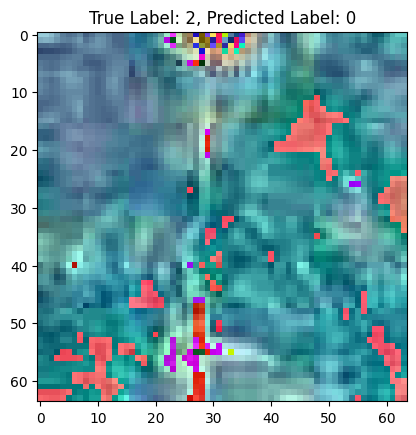

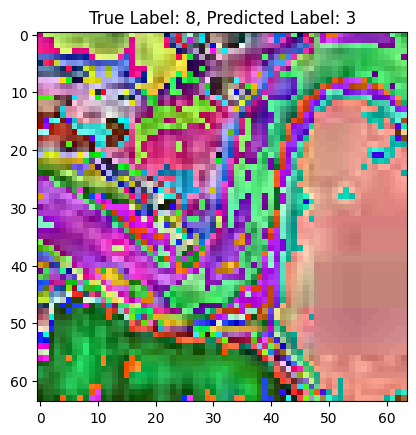

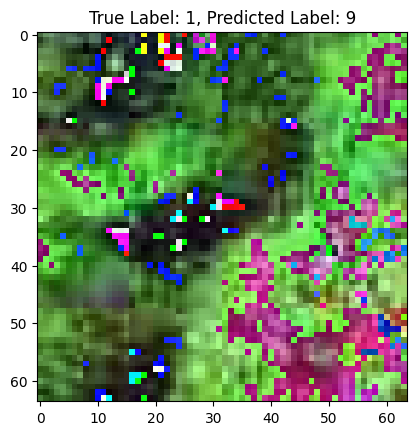

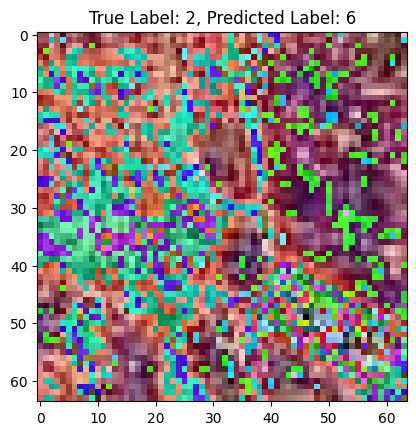

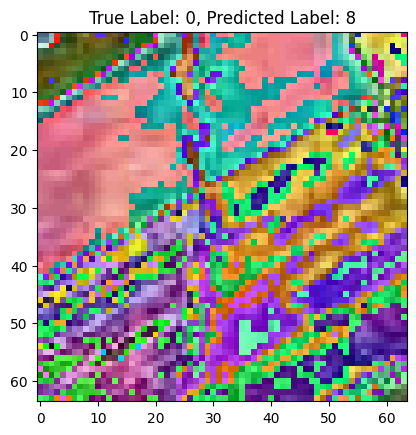

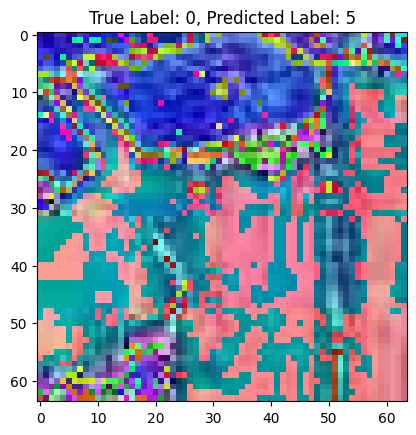

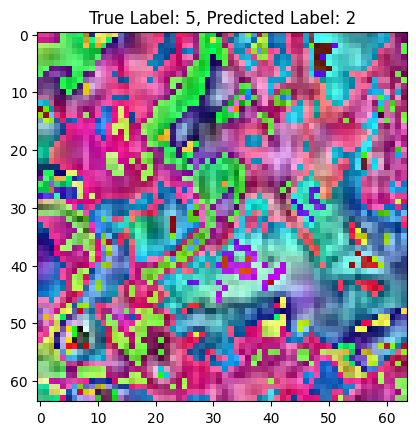

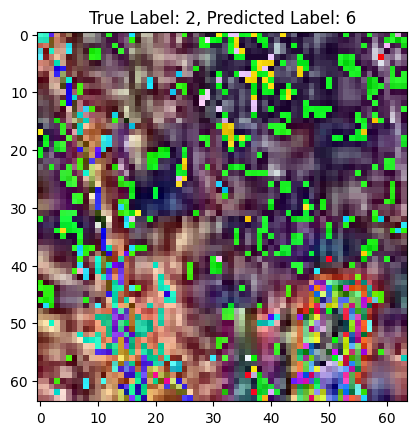

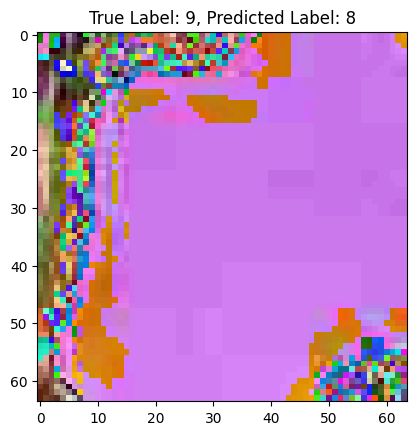

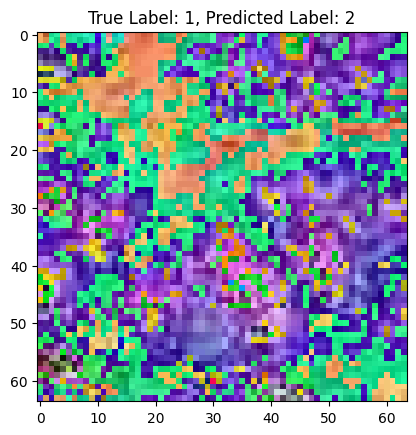

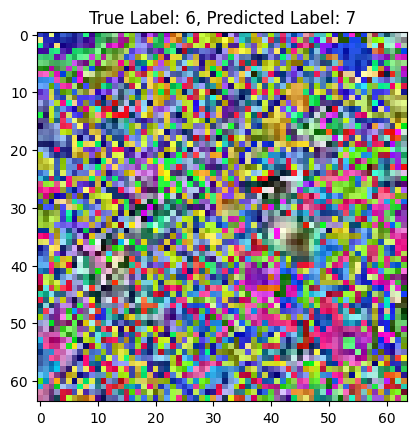

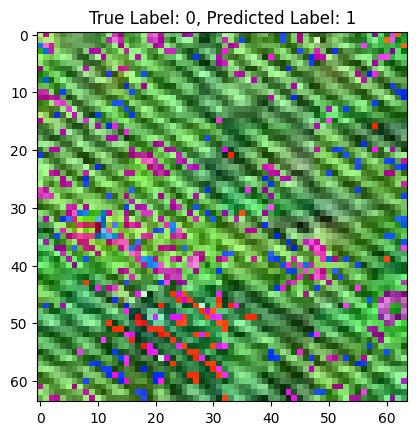

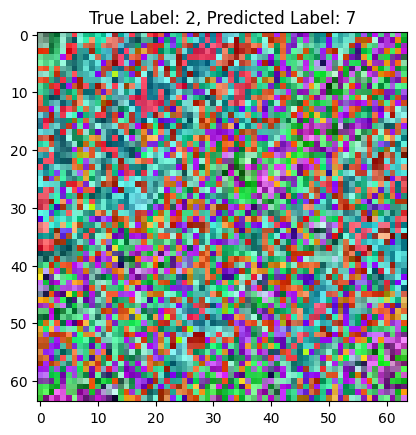

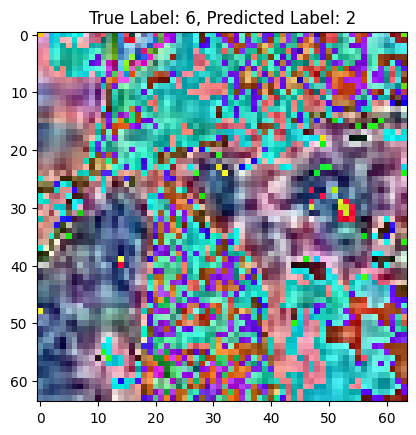

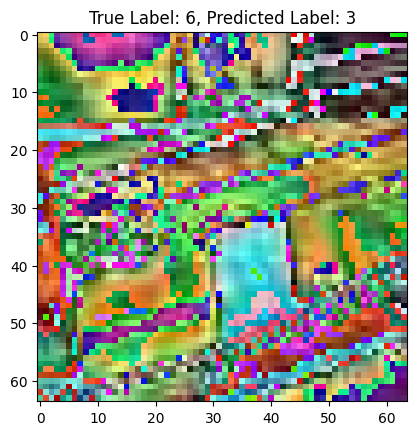

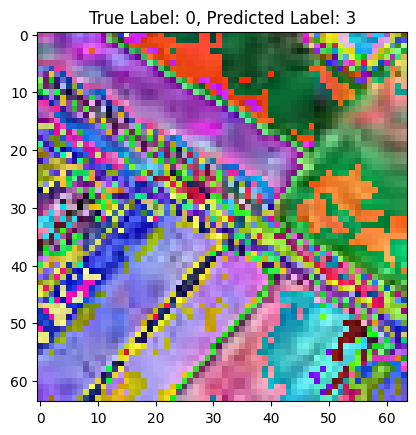

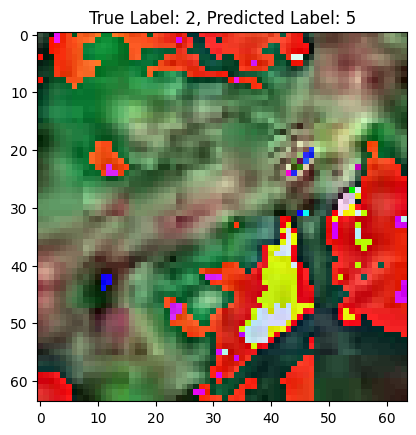

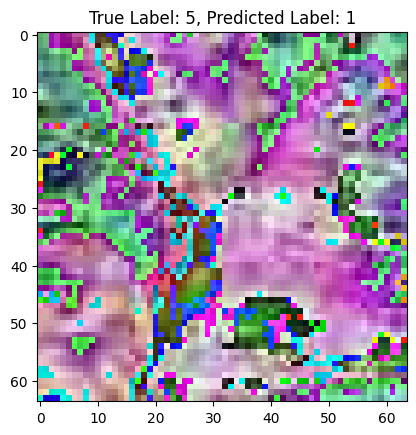

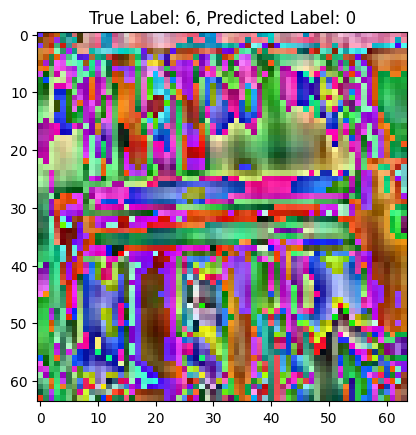

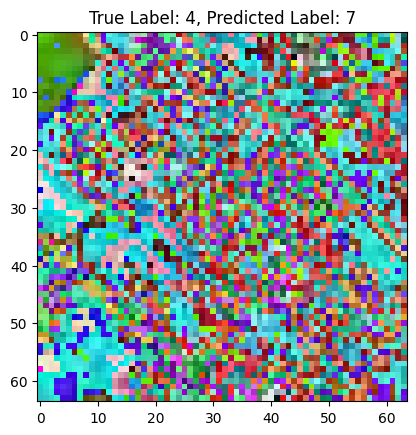

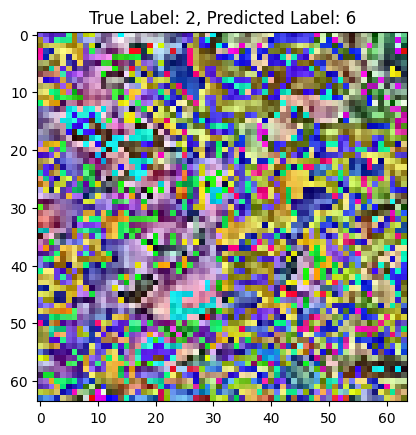

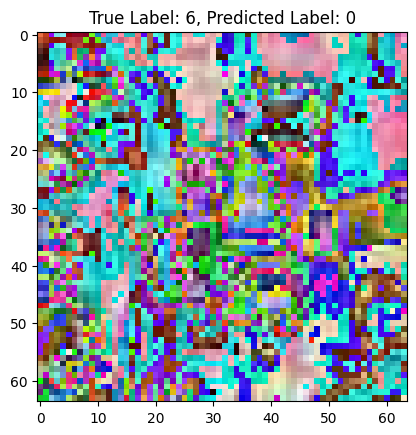

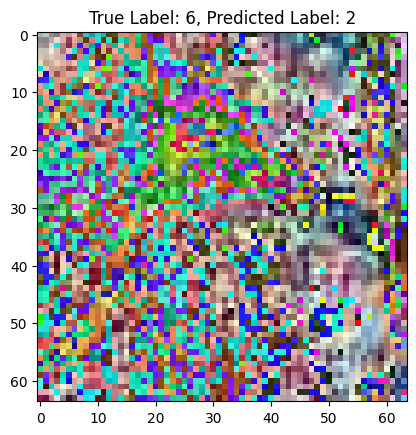

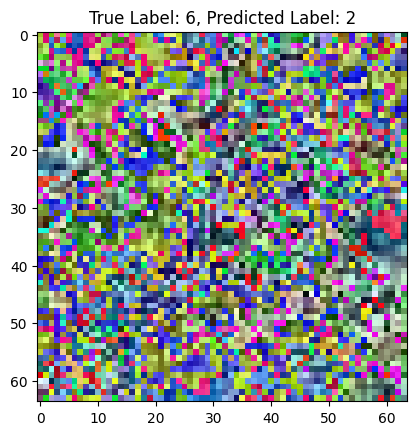

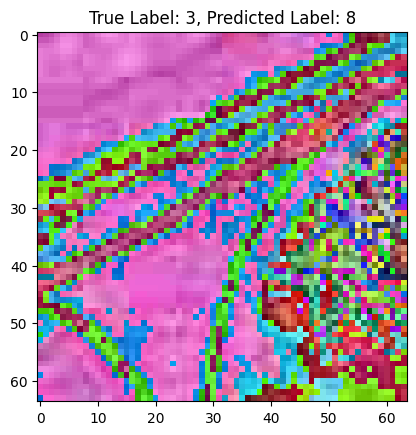

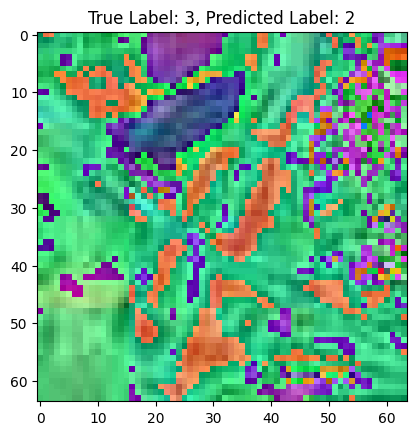

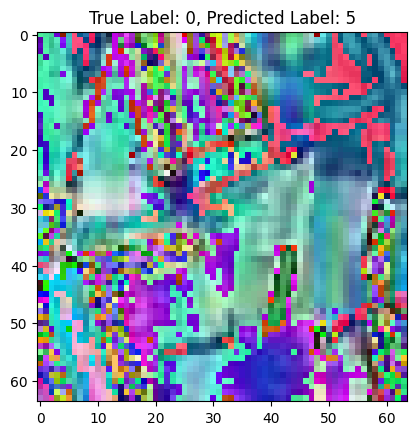

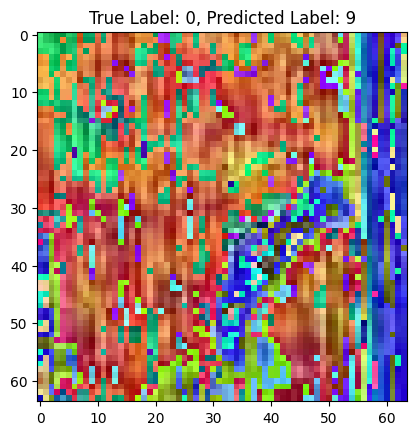

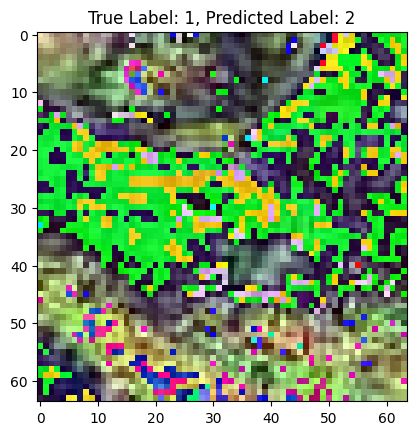

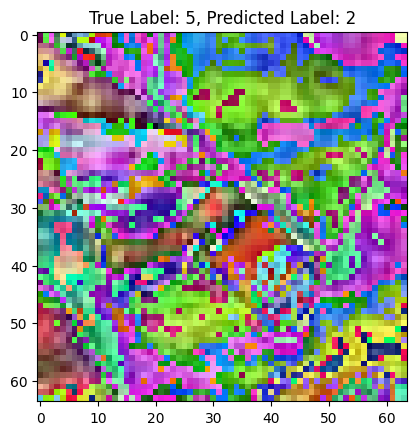

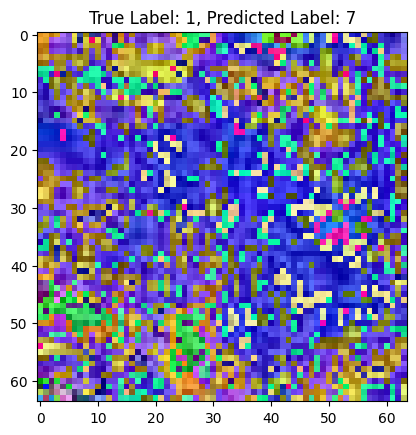

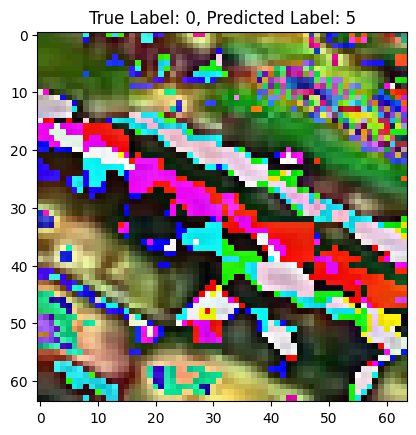

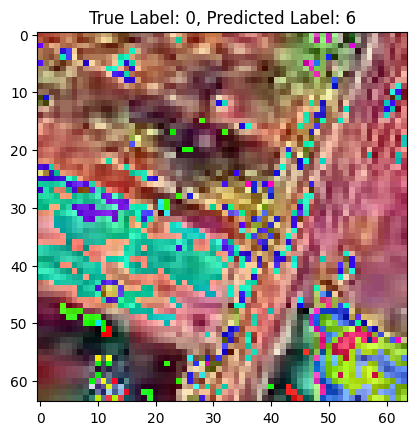

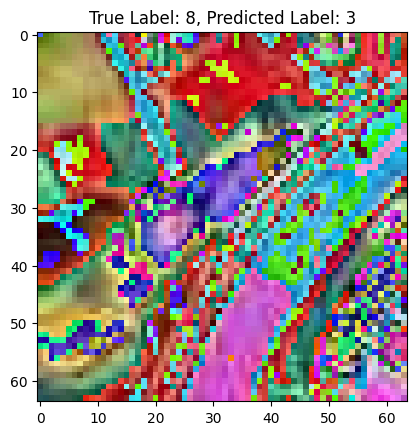

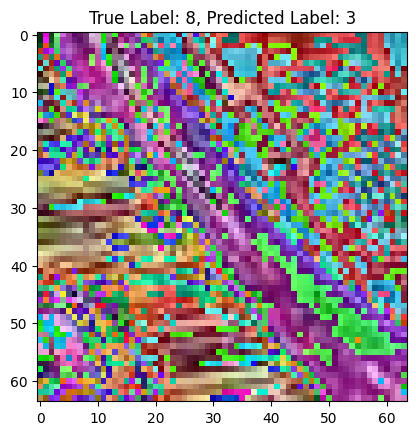

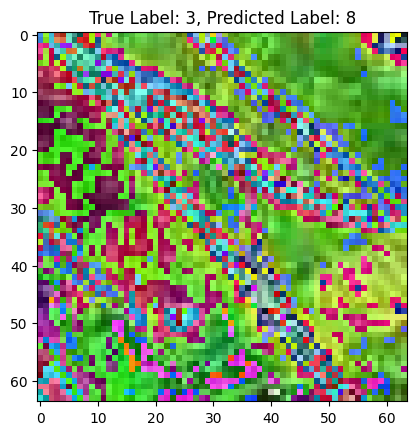

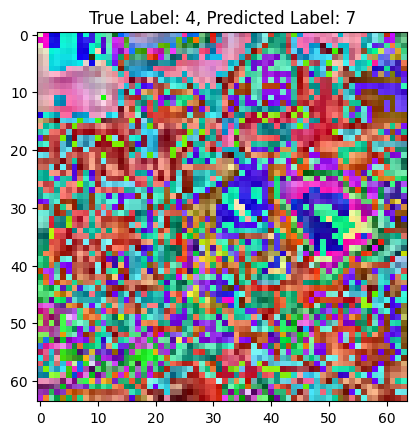

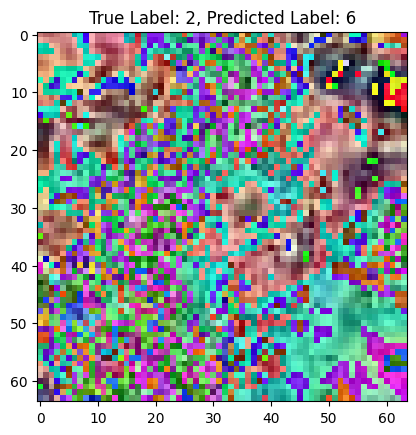

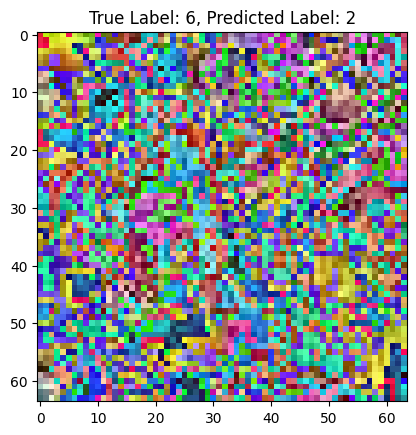

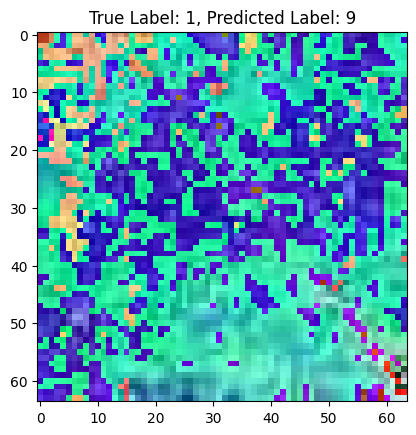

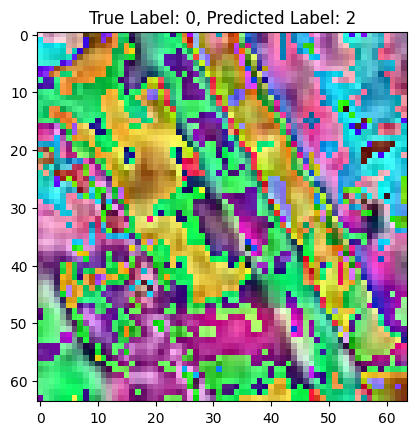

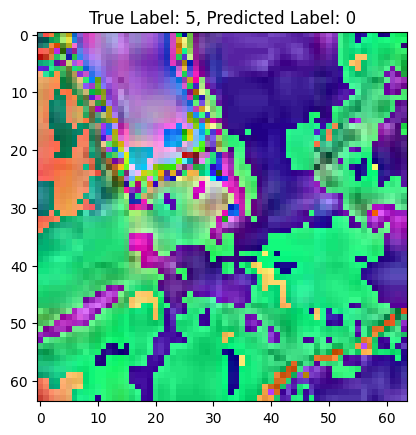

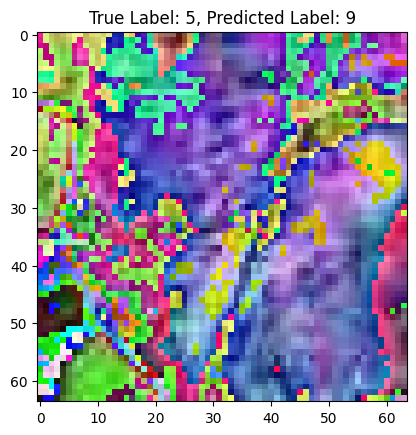

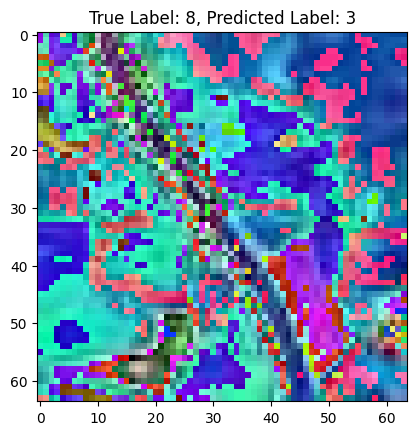

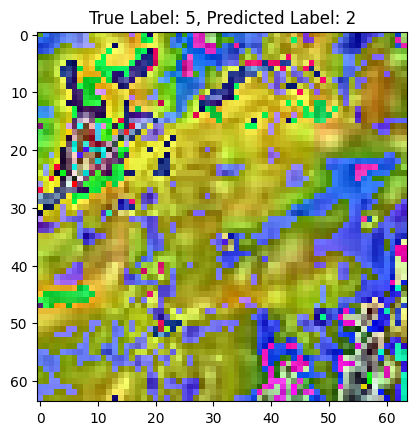

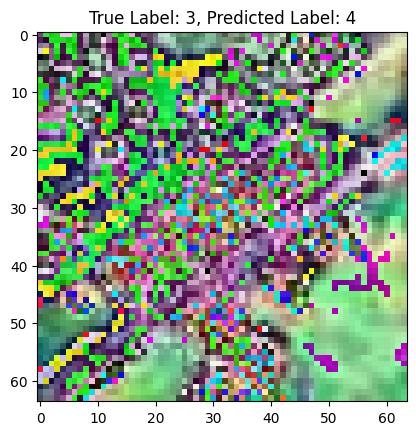

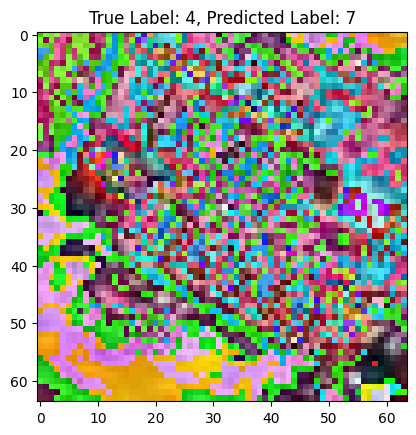

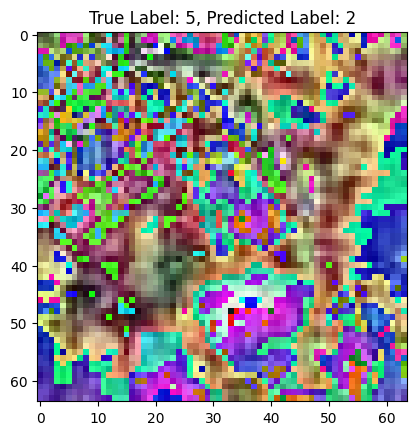

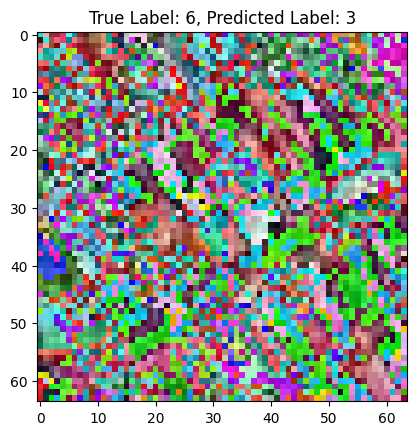

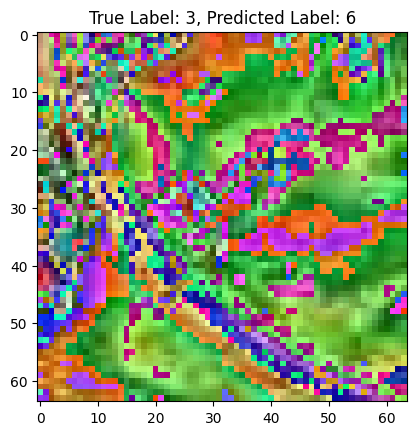

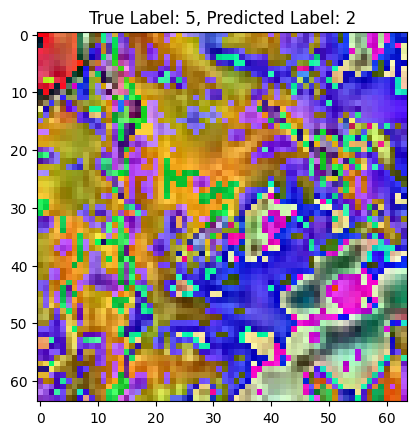

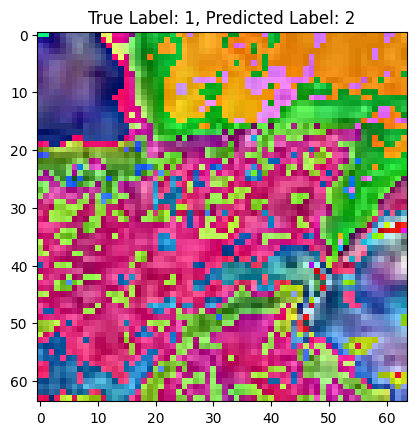

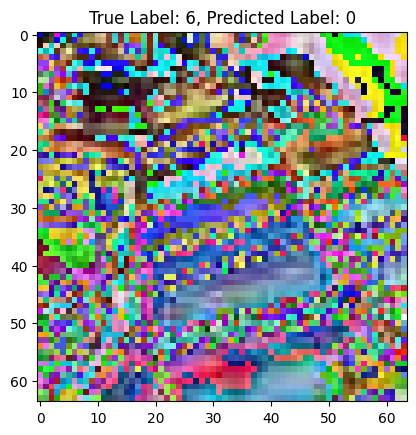

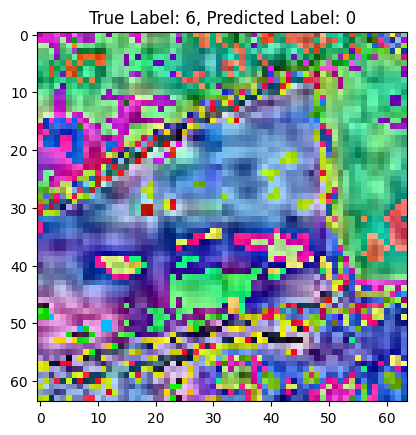

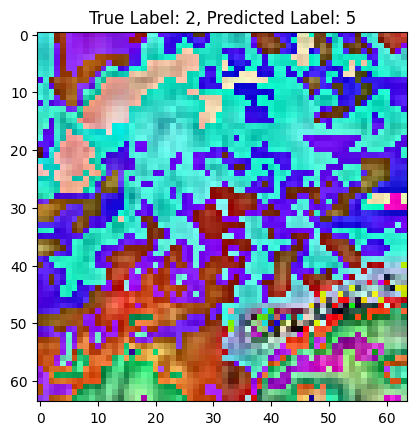

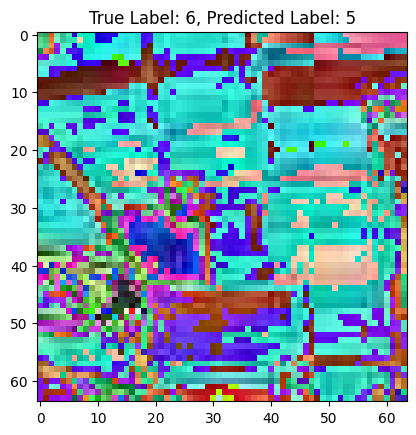

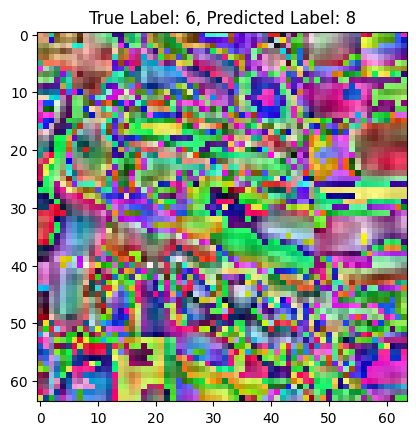

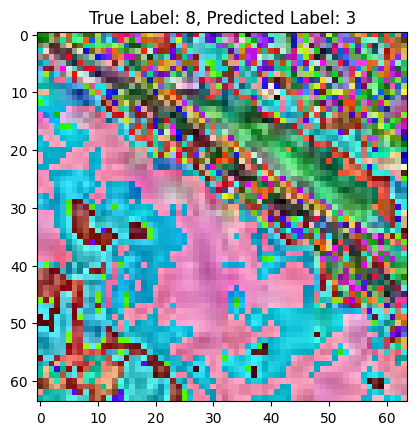

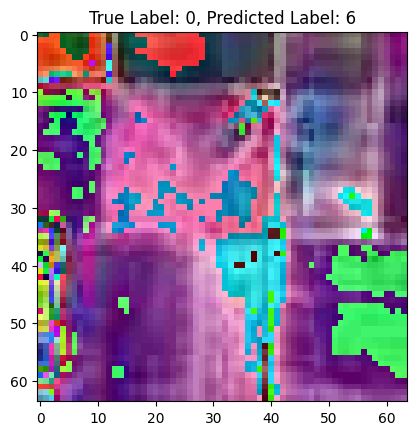

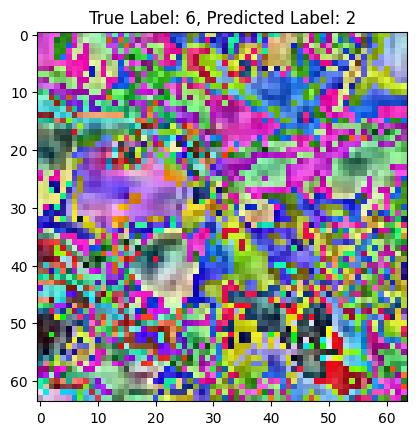

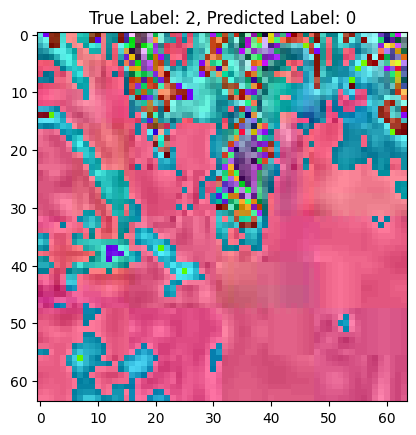

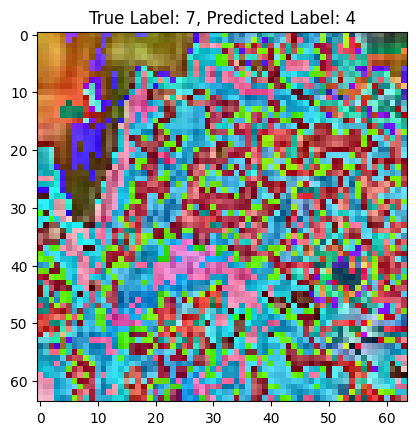

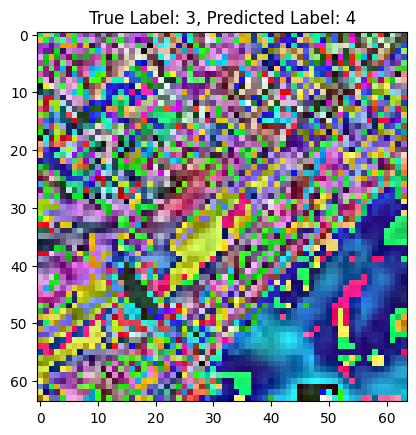

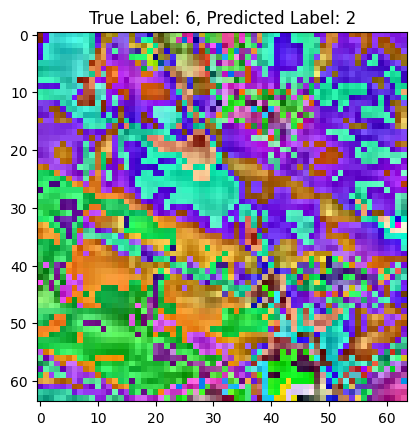

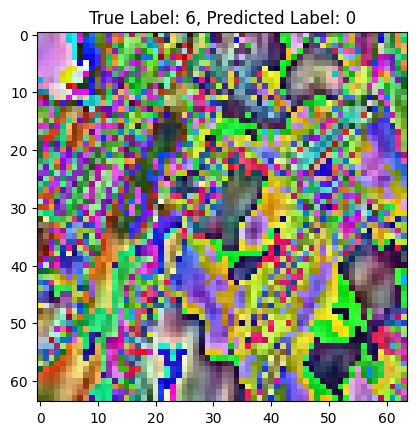

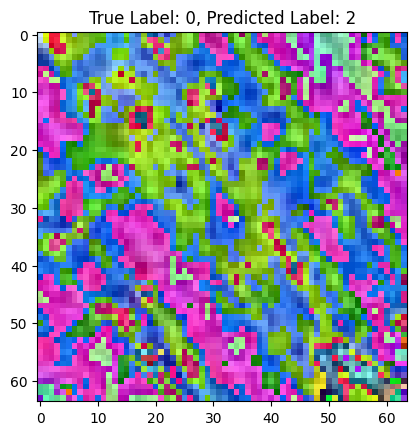

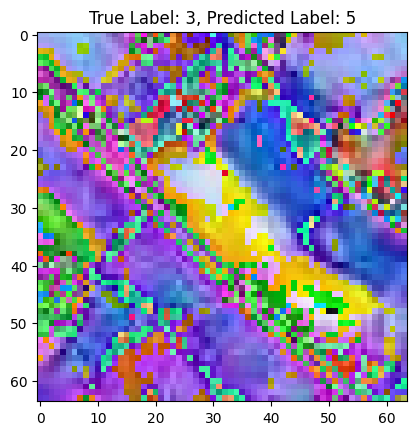

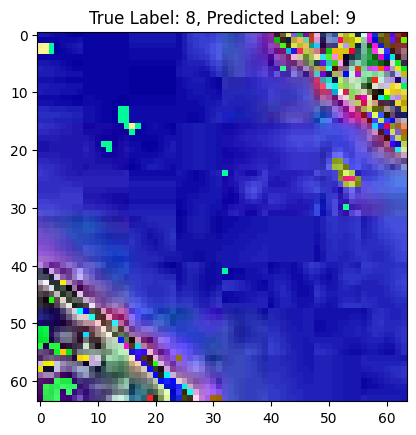

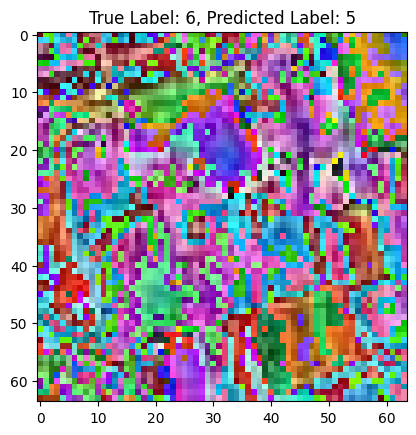

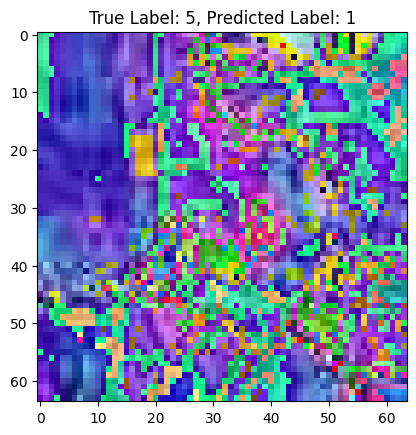

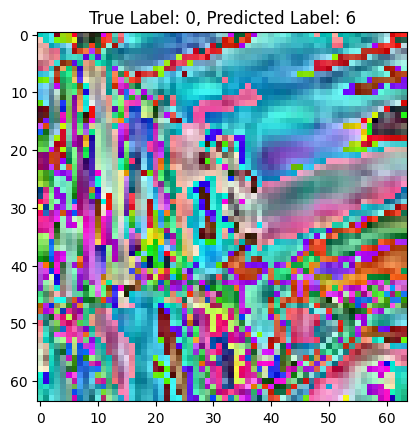

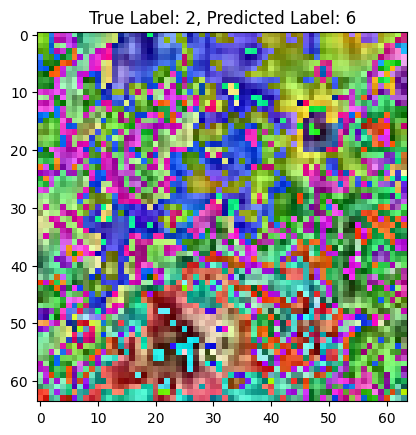

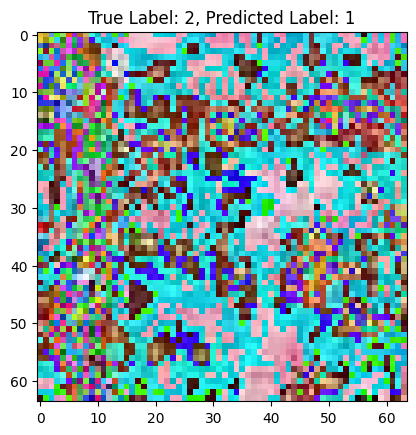

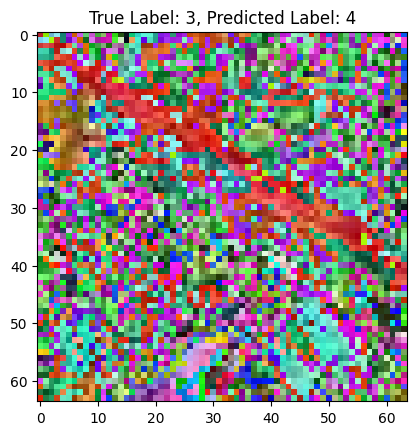

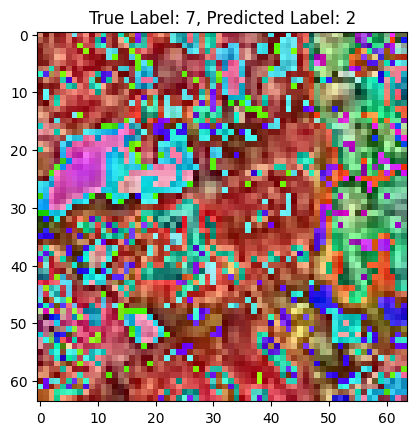

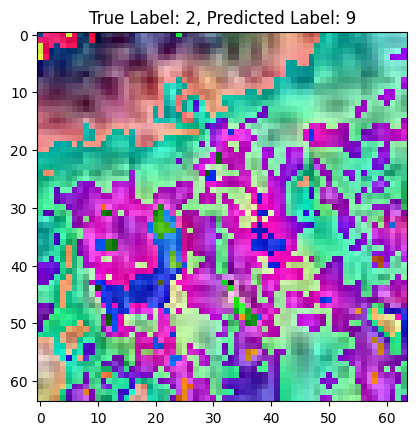

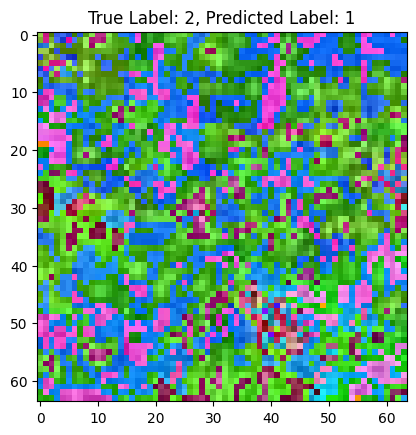

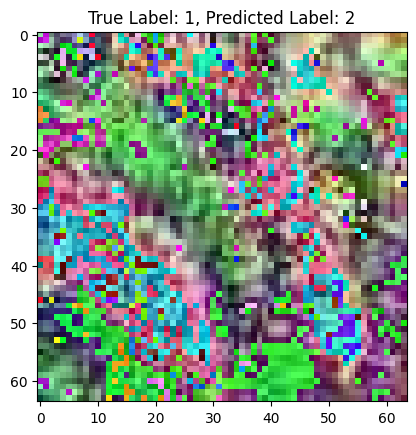

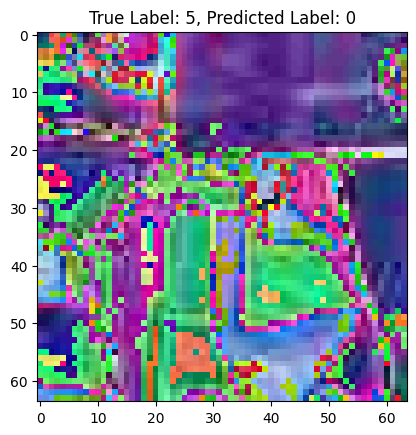

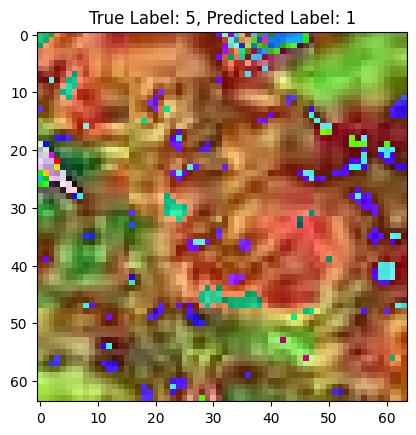

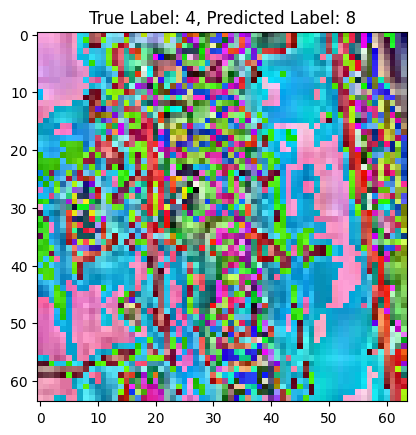

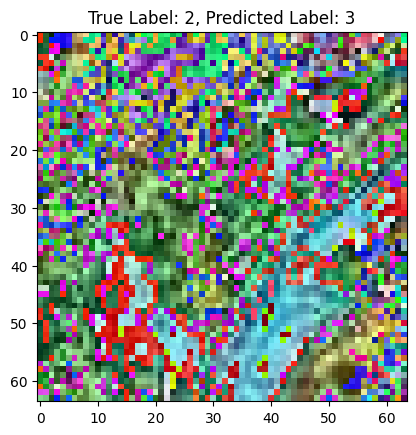

In [28]:
# Visualisez les images des prédictions incorrectes
for prediction in incorrect_predictions:
    image = prediction['image']
    true_label = prediction['true_label']
    predicted_label = prediction['predicted_label']

    # Utilisez la librairie matplotlib ou tout autre moyen pour afficher les images
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()

In [ ]:
# Hyperparamètres à ajuster
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs = 10

# Fonction de formation
def train(model, train_loader, optimizer, criterion):
    model.train()
    for inputs, labels in train_loader:

        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Fonction d'évaluation
def evaluate(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()

    accuracy = correct_predictions / len(val_loader.dataset)
    average_loss = total_loss / len(val_loader)

    return accuracy, average_loss

# Boucle d'entraînement avec validation croisée
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Initialiser le modèle, l'optimiseur et la fonction de perte
        model = fcn.cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Diviser votre ensemble de données en entraînement et validation
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train(model, train_loader, optimizer, criterion)

        accuracy, average_loss = evaluate(model, val_loader, criterion)

        print(f"Learning Rate: {lr}, Batch Size: {batch_size}")
        print(f"Accuracy: {accuracy:.4f}, Average Loss: {average_loss:.4f}")
        print("=" * 50)

Learning Rate: 0.001, Batch Size: 16
Accuracy: 0.9355, Average Loss: 0.1990
Learning Rate: 0.001, Batch Size: 32
Accuracy: 0.9510, Average Loss: 0.1722
Learning Rate: 0.001, Batch Size: 64
Accuracy: 0.9550, Average Loss: 0.1657
Learning Rate: 0.01, Batch Size: 16
Accuracy: 0.8938, Average Loss: 0.3063
Learning Rate: 0.01, Batch Size: 32
Accuracy: 0.9030, Average Loss: 0.2979
Learning Rate: 0.01, Batch Size: 64
Accuracy: 0.9197, Average Loss: 0.2446
Learning Rate: 0.1, Batch Size: 16
Accuracy: 0.6975, Average Loss: 0.8742
Learning Rate: 0.1, Batch Size: 32
Accuracy: 0.7930, Average Loss: 0.6322
Learning Rate: 0.1, Batch Size: 64
Accuracy: 0.8782, Average Loss: 0.3737


# Create Your Submission

In [ ]:
# Function to create a submission file
def create_submission(str, predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open(f'{str}.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [ ]:
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "DUPUIS"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")

create_submission(f"{NAME}_{formatted_date}",predictions)

[[ -1.25509202  -9.99478436 -15.98384762 -10.61012554 -19.80841255
    7.93179703 -11.72694206 -23.66124916  -6.96650505 -11.71691608]
 [-13.5481596  -18.51133347 -12.39325142  -0.19752724   8.8185606
  -10.99739933  -6.50299549  -4.0932312  -12.75298595 -19.27193642]
 [ -8.94136333 -18.66173744  -4.70774174  -5.93500423  -8.03833389
   -6.76341248   8.75328732 -14.85729122 -12.29383469 -23.19756699]
 [ -3.73064733   8.13233089 -10.18069458 -14.99424934 -22.75464821
    0.35105798 -13.20223808 -25.90798759  -6.87458086 -12.4180479 ]
 [-12.26240349 -12.82665348 -12.25760937  -9.27559948 -25.72901726
  -23.17848206 -13.12036419 -23.38796997   8.51575565 -16.58456802]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !
